In [1]:
%reload_ext autoreload
%autoreload 2
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 12})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.rc('figure', figsize=[8, 4])
plt.rc('axes', grid=True)
plt.rcParams.update({'grid.alpha': 0.25})

# import warnings
# warnings.simplefilter("error")

In [2]:
import kalepy as kale

reload(kale.kde)
reload(kale.kernels)
reload(kale.utils)
reload(kale.plot)
reload(kale)

<module 'kalepy' from '/Users/lzkelley/Programs/kalepy/kalepy/__init__.py'>

# demo

# Basic Usage

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import kalepy as kale

from kalepy.plot import nbshow

Generate some random data, and its corresponding distribution function

In [4]:
NUM = int(1e4)
np.random.seed(12345)
# Combine data from two different PDFs
_d1 = np.random.normal(4.0, 1.0, NUM)
_d2 = np.random.lognormal(0, 0.5, size=NUM)
data = np.concatenate([_d1, _d2])

# Calculate the "true" distribution
xx = np.linspace(0.0, 7.0, 100)[1:]
yy = 0.5*np.exp(-(xx - 4.0)**2/2) / np.sqrt(2*np.pi)
yy += 0.5 * np.exp(-np.log(xx)**2/(2*0.5**2)) / (0.5*xx*np.sqrt(2*np.pi))

### Plotting Smooth Distributions

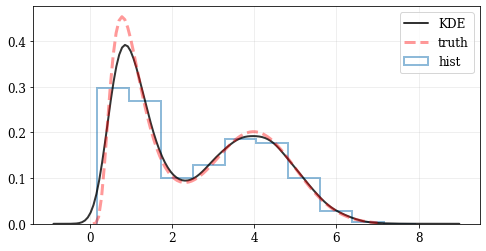

In [5]:
# Reconstruct the probability-density based on the given data points.
# If `points` aren't provided then `kalepy` automatically generates them
points, density = kale.density(data, probability=True)

# Plot the PDF
plt.plot(points, density, 'k-', lw=2.0, alpha=0.8, label='KDE')

# Plot the "true" PDF
plt.plot(xx, yy, 'r--', alpha=0.4, lw=3.0, label='truth')

# Plot the standard, histogram density estimate
plt.hist(data, density=True, histtype='step', lw=2.0, alpha=0.5, label='hist')

plt.legend()
nbshow()

### Constructing statistically similar values

Draw a new sample of data-points from the KDE PDF

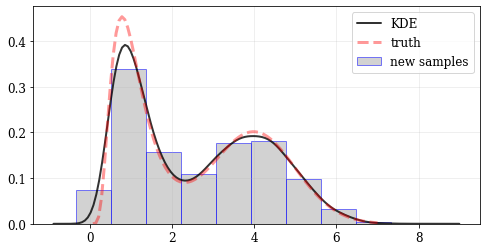

In [6]:
# Draw new samples from the KDE reconstructed PDF
samples = kale.resample(data)

# Plot new samples
plt.hist(samples, density=True, alpha=0.5, label='new samples', color='0.65', edgecolor='b')

# Plot the KDE reconstructed PDF
plt.plot(points, density, 'k-', lw=2.0, alpha=0.8, label='KDE')
# Plot the "true" PDF
plt.plot(xx, yy, 'r--', alpha=0.4, lw=3.0, label='truth')

plt.legend()
nbshow()

### Multivariate Distributions

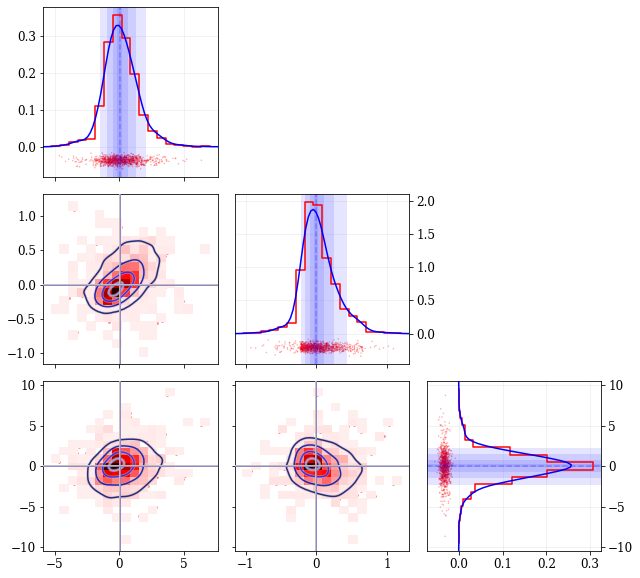

In [7]:
# Load some random-ish data
# data = kale.utils._random_data_3d_01()
data = kale.utils._random_data_3d_02()

# Construct a KDE
kde = kale.KDE(data)

# import kalepy.plot

# Build a corner plot using the `kalepy` plotting submodule
corner = kale.plot.Corner(kde, figsize=[10, 10])

# Data points: red scatter and histograms
corner.plot_data(color='red')

# KDE reconstructed density-distribution: blue contours and curves
corner.plot_kde(color='blue')

nbshow()

# Fancy Usage

## Distribution Functions

### Reflecting Boundaries

What if the distributions you're trying to capture have edges in them, like in a uniform distribution between two bounds?  Here, the KDE chooses 'reflection' locations based on the extrema of the given data.

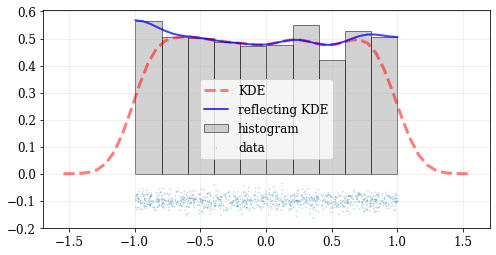

In [8]:
# Uniform data (edges at -1 and +1)
NDATA = 1e3
np.random.seed(54321)
data = np.random.uniform(-1.0, 1.0, int(NDATA))

# Plot the data
kale.plot.carpet(data, label='data')
# Histogram the data
plt.hist(data, density=True, alpha=0.5, label='histogram', color='0.65', edgecolor='k')

# Standard KDE will undershoot just-inside the edges and overshoot outside edges
points, pdf_basic = kale.density(data, probability=True)
plt.plot(points, pdf_basic, 'r--', lw=3.0, alpha=0.5, label='KDE')

# Reflecting KDE keeps probability within given bounds
points, pdf_basic = kale.density(data, reflect=True, probability=True)
plt.plot(points, pdf_basic, 'b-', lw=2.0, alpha=0.75, label='reflecting KDE')

plt.legend()
nbshow()

Explicit reflection locations can also be provided (in any number of dimensions).

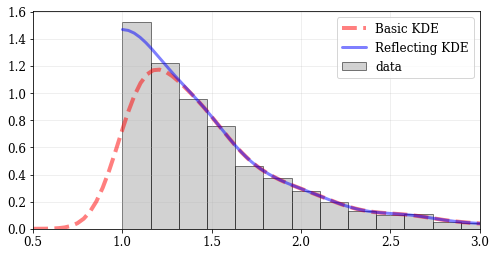

In [9]:
# Construct random data, add an artificial 'edge'
np.random.seed(5142)
edge = 1.0
data = np.random.lognormal(sigma=0.5, size=int(3e3))
data = data[data >= edge]

# Histogram the data, use fixed bin-positions
edges = np.linspace(edge, 4, 20)
plt.hist(data, bins=edges, density=True, alpha=0.5, label='data', color='0.65', edgecolor='k')

# Standard KDE with over & under estimates
points, pdf_basic = kale.density(data, probability=True)
plt.plot(points, pdf_basic, 'r--', lw=4.0, alpha=0.5, label='Basic KDE')

# Reflecting KDE setting the lower-boundary to the known value
#    There is no upper-boundary when `None` is given.
points, pdf_basic = kale.density(data, reflect=[edge, None], probability=True)
plt.plot(points, pdf_basic, 'b-', lw=3.0, alpha=0.5, label='Reflecting KDE')

plt.gca().set_xlim(edge - 0.5, 3)
plt.legend()
nbshow()

### Multivariate Reflection

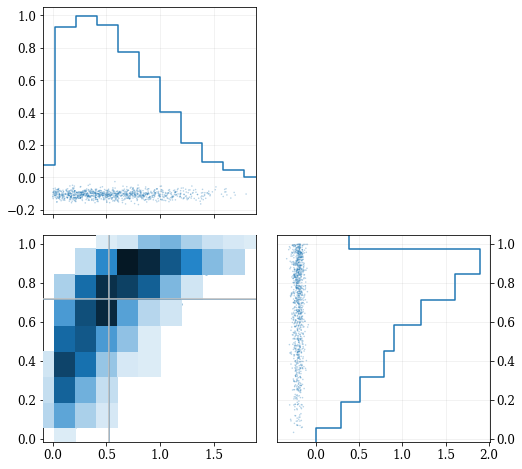

In [10]:
reload(kale.plot)
data = kale.utils._random_data_2d_03()

# Construct a KDE
kde = kale.KDE(data, reflect=[[0, None], [None, 1]])

# kale.plot.corner(kde)

# Build a corner plot using the `kalepy` plotting submodule
# corner = kale.plot.Corner(kde)  #, figsize=[10, 10])

# Data points: red scatter and histograms
# corner.plot_data(color='red', scatter=dict(s=10, alpha=0.15))
# corner.plot(kde=False, data=True, color='red');

# KDE reconstructed density-distribution: blue contours and curves
# corner.plot(kde=True, data=False, color='blue');

corner = kale.plot.Corner(kde)
corner.plot_data()
# corner.plot(kde=False, data=True, color='red');
# corner.plot_data(color='red', dist2d=dict(contour=True, pad=True), scatter=True, sigmas=[0.5, 1, 2])

# axes = corner.axes
# xlim = None
# ylim = None
# for ii in range(2):
#     xlim = zmath.minmax(axes[ii, 0].get_xlim(), prev=xlim)
#     ylim = zmath.minmax(axes[1, ii].get_ylim(), prev=ylim)
    
# axes[1, 0].set(xlim=xlim, ylim=ylim)
# axes[0, 0].set(xlim=xlim)
# axes[1, 1].set(ylim=ylim)



### Specifying Bandwidths and Kernel Functions

### Selecting Particular Parameters/Dimensions

### Cumulative distribution and quartiles (percent-point functions)

## Resampling

### Use different `weights` of the data

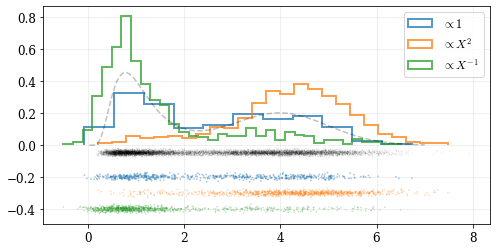

In [11]:
# Draw some random data (and the PDF, for comparison)
data, truth = kale.utils._random_data_1d_01()
# Setup plotting parameters
kw = dict(density=True, histtype='step', lw=2.0, alpha=0.75, bins='auto')

# plot the 'true' distribution
plt.plot(*truth, 'k--', alpha=0.25)
# plot the sampled data with a carpet plot
kale.plot.carpet(data, color='k')

# UNIFORM: resample the data uniformly, 600 samples
col = 'tab:blue'
res = kale.resample(data, size=600)
kale.plot.carpet(res, shift=-0.15, color=col)              # `shift` the carpet plot downwards to not overlap
plt.hist(res, color=col, label=r'$\propto 1$', **kw)

# SQUARE: resample the data proportional to its square
col = 'tab:orange'
res = kale.resample(data, weights=data**2, size=1000)
kale.plot.carpet(res, shift=-0.25, color=col)
plt.hist(res, color=col, label=r'$\propto X^2$', **kw)

# INVERSE: resample the data proportional to its inverse
col = 'tab:green'
res = kale.resample(data, weights=data**-1, size=1000)
kale.plot.carpet(res, shift=-0.35, color=col)
plt.hist(res, color=col, label=r'$\propto X^{-1}$', **kw)

# Add legend
plt.legend()
# display the figure if this is a notebook
nbshow()

### Resampling while 'keeping' certain parameters/dimensions